# Initializing

In [ ]:
!pip install torchinfo

from torchinfo import summary
import numpy as np
from tensorflow.keras.models import load_model
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2 as cv
from scipy.linalg import hadamard
from scipy.ndimage import shift
import os
import torch


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%run '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/MyWatermarkinClasses.ipynb'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loaded Image

In [ ]:
## Test Images (Unseen Images)
#folder_path = '/content/drive/My Drive/Colab Notebooks/Image/COCO_Gray_Test_512'
folder_path = '/content/drive/My Drive/Colab Notebooks/Image/COCO_Gray_Validation_512'

test_image_array = []
#target_size = (128, 128)  # Resize to desired shape (width, height)

for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
        img_path = os.path.join(folder_path, filename)
        my_image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        im = my_image.astype(np.float32)
        im = np.expand_dims(im, axis=-1)
        im = im / 255.0
        im = im[:,:,0]
        test_image_array.append(im)

# Hyper Parameters

In [ ]:
# Mask Ratio
mask_ratio = 0.5

# Itteration
cnn_iterations = 500

# ** Loaded Model

In [ ]:
# Universal Attack
model_path = '/content/drive/MyDrive/Colab Notebooks/CNN_WavePattern_Noise/Pre_Trained_Models/Models/universal5_resnet18_4class.pth'


# Load the saved model
model = torch.load(model_path, map_location=torch.device('cpu'), weights_only=False)
model.eval()
summary(model, input_size=(1, 1, 128, 128))  # (batch_size, channels, height, width)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 4]                    --
├─Conv2d: 1-1                            [1, 64, 64, 64]           3,136
├─BatchNorm2d: 1-2                       [1, 64, 64, 64]           128
├─ReLU: 1-3                              [1, 64, 64, 64]           --
├─MaxPool2d: 1-4                         [1, 64, 32, 32]           --
├─Sequential: 1-5                        [1, 64, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-3                    [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-4                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 32, 32]           128
│    │    └─ReLU: 3-6                    [1, 64, 32, 32]           --
│

# Complete Watermarking Process

## Splited Image

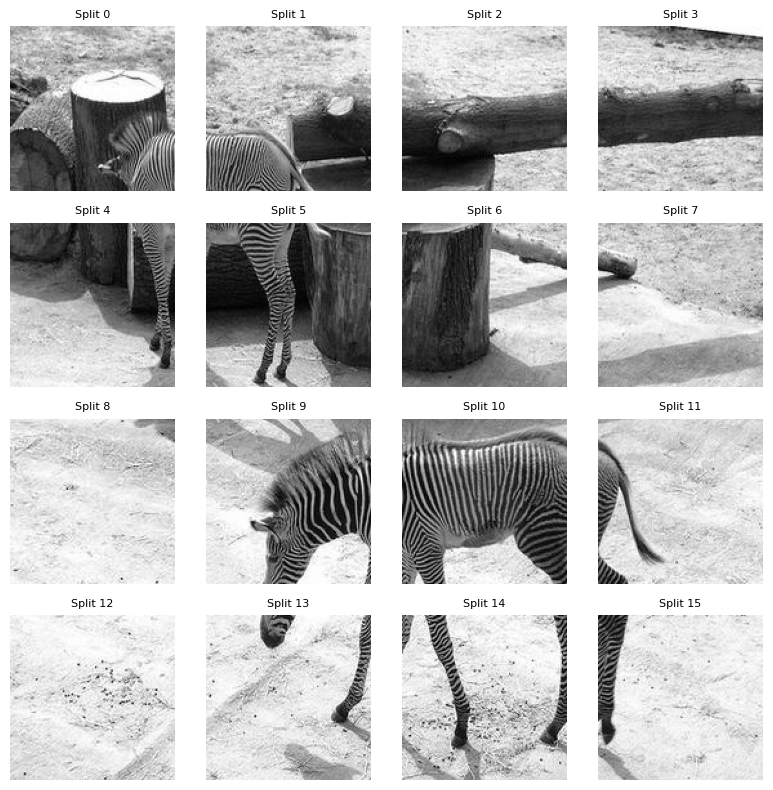

In [ ]:
def get_image_split(im, split_num):
    """
    Splits a 512x512 grayscale image into 16 (128x128) blocks and returns the specified block.

    Parameters:
    - image: 2D numpy array of shape (512, 512)
    - split_num: Integer in [0, 15], indicating which split to return

    Returns:
    - 2D numpy array of shape (128, 128)
    """
    if im.shape != (512, 512):
        raise ValueError("Image must be 512x512.")
    if not (0 <= split_num < 16):
        raise ValueError("split_num must be in range 0 to 15.")

    row = split_num // 4
    col = split_num % 4

    start_y = row * 128
    start_x = col * 128

    return im[start_y:start_y + 128, start_x:start_x + 128]

# Example usage
def show_all_splits(im):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(16):
        split = get_image_split(im, i)
        row = i // 4
        col = i % 4
        axes[row, col].imshow(split, cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(f"Split {i}", fontsize=8)
    plt.tight_layout()
    plt.show()

_index = 4
show_all_splits(test_image_array[_index])

## Watermarking

### Embedding

In [ ]:
def complete_CNN_embedding(im, watermark_bits, mask_ratio):

  full_watermarked = np.zeros_like(im)  # same shape as im
  pn_dict = {}

  for split_num in range(16):  # 0 to 15 inclusive

    split_im = get_image_split(im, split_num)
    bit_pair = watermark_bits[2 * split_num : 2 * split_num + 2]

    watermarking = CNNWatermarking(split_im, mask_ratio)
    watermarked_block = watermarking.embedding(bit_pair)

    # Put watermarked block back into full image
    row = split_num // 4
    col = split_num % 4
    start_y = row * 128
    start_x = col * 128

    full_watermarked[start_y:start_y + 128, start_x:start_x + 128] = watermarked_block

  return full_watermarked

### Reconstruction

In [ ]:
def complete_CNN_reconstruction(full_watermarked, model):

  reconstruction_bits = []

  for split_num in range(16):  # 0 to 15 inclusive

    split_watermarked = get_image_split(full_watermarked, split_num)

    watermarking = CNNWatermarking(split_watermarked, mask_ratio)
    bits = watermarking.reconstruction(model)

    reconstruction_bits.extend(bits.flatten())

  return np.array(reconstruction_bits)

# Evaluation

In [ ]:
def calculate_ber(original_array, reconstructed_array):
    # Ensure the arrays are the same length
    if len(original_array) != len(reconstructed_array):
        raise ValueError("Arrays must have the same length")

    errors = np.sum(original_array != reconstructed_array)  # Count differing bits
    ber = errors / len(original_array)                      # BER = errors / total bits
    return ber

## Noise

### Random Noise

In [ ]:
noise_strength = 1.03

total_ber = 0

for i in range(cnn_iterations):
  print(f"Iteration {i+1}/{cnn_iterations}", end='\r')
  watermark_bits = np.random.choice([0, 1], size=32)

  index = np.random.randint(0, len(test_image_array))
  im = test_image_array[index]

  full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

  # Channel
  channel = Channel(full_watermarked)
  noisy_watermarked = channel.add_random_noise(noise_strength)

  reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
  total_ber += calculate_ber(watermark_bits, reconstruction_bits)

avg_ber = total_ber / cnn_iterations
print(f"Noise Strength = {noise_strength:.2f} | Avg_BER = {avg_ber * 100:.2f}%")

KeyboardInterrupt: 

### Guassian Noise

In [ ]:
standard_deviation = 0.05

total_ber = 0

for i in range(cnn_iterations):
  print(f"Iteration {i+1}/{cnn_iterations}", end='\r')
  watermark_bits = np.random.choice([0, 1], size=32)

  index = np.random.randint(0, len(test_image_array))
  im = test_image_array[index]

  full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

  # Channel
  channel = Channel(full_watermarked)
  noisy_watermarked = channel.add_guassian_noise(0, standard_deviation)

  reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
  total_ber += calculate_ber(watermark_bits, reconstruction_bits)

avg_ber = total_ber / cnn_iterations
print(f"standard_deviation = {standard_deviation:.2f} | Avg_BER = {avg_ber * 100:.2f}%")


standard_deviation = 0.05 | Avg_BER = 0.70%


## Filter

### Blur Attack

In [ ]:
filter_size = 5

total_ber = 0

for i in range(cnn_iterations):
  print(f"Iteration {i+1}/{cnn_iterations}", end='\r')
  watermark_bits = np.random.choice([0, 1], size=32)

  index = np.random.randint(0, len(test_image_array))
  im = test_image_array[index]

  full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

  # Channel
  channel = Channel(full_watermarked)
  noisy_watermarked = channel.blur_image(filter_size)

  reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
  total_ber += calculate_ber(watermark_bits, reconstruction_bits)

avg_ber = total_ber / cnn_iterations
print(f"Filter Size = {filter_size:.2f} | Avg_BER = {avg_ber * 100:.2f}%")

Filter Size = 5.00 | Avg_BER = 20.24%


### Brightness Attack

In [ ]:
brightness_value = 0.5

total_ber = 0

for i in range(cnn_iterations):
  print(f"Iteration {i+1}/{cnn_iterations}", end='\r')
  watermark_bits = np.random.choice([0, 1], size=32)

  index = np.random.randint(0, len(test_image_array))
  im = test_image_array[index]

  full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

  # Channel
  channel = Channel(full_watermarked)
  noisy_watermarked = channel.brightness_attack(brightness_value)

  reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
  total_ber += calculate_ber(watermark_bits, reconstruction_bits)

avg_ber = total_ber / cnn_iterations
print(f"Brightness Value = {brightness_value:.2f} | Avg_BER = {avg_ber * 100:.2f}%")

Brightness Value = 0.50 | Avg_BER = 22.50%


### Contrast Attack

In [ ]:
contrast_value = 0.5

total_ber = 0

for i in range(cnn_iterations):
  print(f"Iteration {i+1}/{cnn_iterations}", end='\r')
  watermark_bits = np.random.choice([0, 1], size=32)

  index = np.random.randint(0, len(test_image_array))
  im = test_image_array[index]

  full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

  # Channel
  channel = Channel(full_watermarked)
  noisy_watermarked = channel.contrast_attack(contrast_value)

  reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
  total_ber += calculate_ber(watermark_bits, reconstruction_bits)

avg_ber = total_ber / cnn_iterations
print(f"Contrast Value = {contrast_value:.2f} | Avg_BER = {avg_ber * 100:.2f}%")

Contrast Value = 0.50 | Avg_BER = 0.35%


## Geometric

### Shift Attack

In [ ]:
shift_val = 20

total_ber = 0

for i in range(cnn_iterations):
  print(f"Iteration {i+1}/{cnn_iterations}", end='\r')
  watermark_bits = np.random.choice([0, 1], size=32)

  index = np.random.randint(0, len(test_image_array))
  im = test_image_array[index]

  full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

  # Channel
  channel = Channel(full_watermarked)
  noisy_watermarked = channel.x_shift_attack(shift_val)

  reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
  total_ber += calculate_ber(watermark_bits, reconstruction_bits)

avg_ber = total_ber / cnn_iterations
print(f"Shift Value = {shift_val:.2f} | Avg_BER = {avg_ber * 100:.2f}%")

Shift Value = 20.00 | Avg_BER = 7.16%


### Rotation Attack

In [ ]:
angle = 5

total_ber = 0

for i in range(cnn_iterations):
  print(f"Iteration {i+1}/{cnn_iterations}", end='\r')
  watermark_bits = np.random.choice([0, 1], size=32)

  index = np.random.randint(0, len(test_image_array))
  im = test_image_array[index]

  full_watermarked = complete_CNN_embedding(im, watermark_bits, mask_ratio)

  # Channel
  channel = Channel(full_watermarked)
  noisy_watermarked = channel.rotation_attack(angle)

  reconstruction_bits = complete_CNN_reconstruction(noisy_watermarked, model)
  total_ber += calculate_ber(watermark_bits, reconstruction_bits)

avg_ber = total_ber / cnn_iterations
print(f"Rotation Angle = {angle:.2f} | Avg_BER = {avg_ber * 100:.2f}%")

Rotation Angle = 5.00 | Avg_BER = 39.92%
